# RAIL SOMPZ Informer

**Author:** Sam Schmidt, Justin Myles

**Last Successfully Run:** June 12, 2024

This notebook will demonstrate the training of the "deep" and "wide" Self-Organized Maps (SOMs) used by `rail_sompz`.  `rail_sompz` is a ported version of the Dark Energy Survey (DES) SOM-based tomographic redshift bin software.
This notebook relies on methods and code developed originally for the following publications:

A. Campos et al. (DES Collaboration) - Enhancing weak lensing redshift distribution characterization by optimizing the Dark Energy Survey Self-Organizing Map Photo-z method (in preparation)

[C. Sánchez, M. Raveri, A. Alarcon, G. Bernstein - Propagating sample variance uncertainties in redshift calibration: simulations, theory, and application to the COSMOS2015 data](https://doi.org/10.1093/mnras/staa2542)

[R. Buchs, et al. - Phenotypic redshifts with self-organizing maps: A novel method to characterize redshift distributions of source galaxies for weak lensing](https://doi.org/10.1093/mnras/stz2162)

[J. Myles, A. Alarcon, et al. (DES Collaboration) - Dark Energy Survey Year 3 results: redshift calibration of the weak lensing source galaxies](https://doi.org/10.1093/mnras/stab1515)

Like other RAIL estimators and summarizers, `rail_sompz` consists of an informer stage and an estimator stage, in this case `SOMPZInformer` and `SOMPZEstimator`.  `SOMPZInformer` takes in both the "deep" data (usually taken over a smaller area than our "wide" data, and usually including additional photometric bands) and "wide" data and trains a pair of SOMs that will be used by the estimator stage.  

There are a number of **configuration parameters** that the stage uses to control aspects of the SOM training:
- redshift_col: the name of the redshift column
- deep_groupname: the hdf5_groupname for deep data
- wide_groupname: the hdf5_groupname for wide data
- inputs_deep: the list of the names of columns to be used as inputs for deep data
- input_errs_deep: the list of the names of columns containing errors on inputs for deep data
- inputs_wide: the list of the names of columns to be used as inputs for wide data
- input_errs_wide: the list of the names of columns containing errors on inputs for wide data
- zero_points_deep: the list of zero points for converting mags to fluxes for deep data, if needed
- zero_points_wide: the list of zero points for converting mags to fluxes for wide data, if needed
- som_shape_deep: a tuple defining the shape for the deep som, must be a 2-element tuple, e.g. `(32, 32)`
- som_shape_wide: a tuple defining the shape for the wide som, must be a 2-element tuple, e.g. `(25, 25)`
- som_minerror_deep: the floor value placed on observational error on each feature in deep som
- som_minerror_wide: the floor value placed on observational error on each feature in wide som
- som_wrap_deep: boolean flag to set whether the deep SOM has periodic boundary conditions
- som_wrap_wide: boolean flag to set whether the wide SOM has periodic boundary conditions
- som_take_log_deep: boolean flag to set whether to take log of inputs (i.e. for fluxes) for deep som
- som_take_log_wide: boolean flag to set whether to take log of inputs (i.e. for fluxes) for wide som
- convert_to_flux_deep: boolean flag for whether to convert input columns to fluxes for deep data, set to true if inputs are mags and to False if inputs are already fluxes
- convert_to_flux_wide: boolean flag for whether to convert input columns to fluxes for wide data
- set_threshold_deep: boolean flag for whether to replace values below a threshold with a set number
- thresh_val_deep: threshold value for set_threshold for deep data
- set_threshold_wide: boolean flag for whether to replace values below a threshold with a set number
- thresh_val_wide: threshold value for set_threshold for wide data

We will set several of these values in our example, any values not explicitly set will revert to their defaults.  

Let's start by importing a few packages, including `SOMPZInformer` and setting up the RAIL DataStore:

In [1]:
# usual imports
import os
import numpy as np
#from rail.core.utils import RAILDIR
import matplotlib.pyplot as plt

In [2]:
from rail.estimation.algos.sompz import SOMPZInformer

In [3]:
from rail.core.data import TableHandle
from rail.core.stage import RailStage

In [4]:
DS = RailStage.data_store
DS.__class__.allow_overwrite = True

Next, let's read in some test data. We'll use some small datasets drawn from the Roman-DESC simulations, and where we have incorporated expected 10-year depth photometric uncertainties into the data via the photerr-based error models in RAIL.

The SOMPZ method usually leverages a "deep" dataset with extra bands (often in the near-infrared), where the extra photometric information in the extended wavelength coverage enables a magnitudes/colors -> redshift mapping with less degeneracies than when using optical colors along.  For this demo, we will use data from the Rubin-Roman simulation [Citation needed!], which does contain simluated photometry for both the Rubin optical `ugrizy` bands as well as the Roman `JHFK` bands.  The Roman `J`, `H`, `F`, and `K` bands have central wavelengths of approximately 1.29, 1.58, 1.84, and 2.13 microns respectively.

We have prepared several data files consisting of simulated Roman-DESC data, the cell below contains (commented) commands to fetch those files from NERSC.  There are two sets of files included in the tar file, one set contains 37,500 "specz" galaxies (which are a subset of a set of 75,000 "deep/balrog" galaxies, and a set of 100,000 "wide field" galaxies.  The other set consists of a subset of these galaxies where we only take 5% of each of the larger samples (so 1875 specz, 3750 "deep", and 5000 "wide" galaxies.  The larger files will give a more robust mapping in our SOM given the extra training data, but will take longer.  The smaller files will give results that do not look as nice, but are large enough to showcase the method while running much faster.  You can comment or uncomment the three files in the cells below to switch from the "small" files to the "large" files if you do not mind some extra run time.

For the "deep" SOM, the data file is named `romandesc_deep_data_37c_noinf.hdf5` and includes the LSST `ugrizy` bands as well as the Roman `JHF` bands (we leave off the K-band for simplicity), for a total of **nine** bands.  The extra near-infrared information in the `JHF` bands will be crucial in mapping out the color to redshift relation for our deep sample.   The galaxies in this file are trimmed to include only galaxies with i<25.0.  This sample size is smaller than those that we will typically use, but enough for a functional example.


For the "wide" som, the data file is named `romandesc_wide_data_50c_noinf.hdf5` and we will only use the `ugrizy` bands in the analysis.  There are 5000 galaxies in this file.

The cell below, if uncommented, will fetch a tar file from NERSC and copy the files to a subdirectory named DEMODATA:

### Uncomment the commands in the cell below to grab the data files to run this demo!

In [5]:
!curl -O https://portal.nersc.gov/cfs/lsst/PZ/roman_desc_demo_data.tar.gz
!mkdir DEMODATA
!tar -xzvf roman_desc_demo_data.tar.gz
!mv romandesc*.hdf5 DEMODATA/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 60.0M  100 60.0M    0     0  75.3M      0 --:--:-- --:--:-- --:--:-- 75.3M
romandesc_deep_data_37c_noinf.hdf5
romandesc_deep_data_75k_noinf.hdf5
romandesc_spec_data_18c_noinf.hdf5
romandesc_spec_data_37k_noinf.hdf5
romandesc_wide_data_100k_noinf.hdf5
romandesc_wide_data_50c_noinf.hdf5


Now, let's add our deep and wide datasets to the DataStore:

In [6]:
# For the demo to run quickly on the small files, leave these to lines uncommented
trainFileDeep = './DEMODATA/romandesc_deep_data_37c_noinf.hdf5'
trainFileWide = './DEMODATA/romandesc_wide_data_50c_noinf.hdf5'
# to switch to larger files that will take a bit longer but yield slightly better results
# switch to these two larger files
#trainFileDeep = './DEMODATA/romandesc_deep_data_75k_noinf.hdf5'
#trainFileWide = './DEMODATA/romandesc_wide_data_100k_noinf.hdf5'
deep_data = DS.read_file("input_deep_data", TableHandle, trainFileDeep)
wide_data = DS.read_file("input_wide_data", TableHandle, trainFileWide)

Let's take a look at what the names of the columns are in the deep file:

In [7]:
print('\n'.join(sorted(deep_data().keys())))

F
F_err
H
HF
HF_err
H_err
J
JH
JH_err
J_err
ROMAN_obs_F184
Y
Y_err
g
g_err
gr
gr_err
i
i_err
iz
iz_err
r
r_err
redshift
ri
ri_err
u
u_err
ug
ug_err
y
yJ
yJ_err
y_err
z
z_err
zy
zy_err


We have the Rubin `ugrizy` bands and their errors with names like `u` and `u_err`, the Roman NIR bands `YJHF` and their errors, and the colors for adjacent bands, e.g. `ug` is really `u-g`.  We will use just the magnitude quantities and not the colors when constructing our example SOM (for more information on this choice, see the Appendix A of Sánchez et al. 2020) .  For our "deep" SOM we will use all of `ugrizyJHF`, while for the "wide" SOM we will use only `ugrizy`.  Let's set up some lists with our magnitudes that will be used in our configs.  The SOM also requires a zero point if we are going to convert to flux (which we are), so we will supply default zero points of 30.0 for all bands in this demo:

In [8]:
bands = ['u','g','r','i','z','y','J','H','F']

deepbands = []
deeperrs = []
zeropts = []
for band in bands:
    deepbands.append(f'{band}')
    deeperrs.append(f'{band}_err')
    zeropts.append(30.)

widebands = []
wideerrs = []  
for band in bands[:6]:
    widebands.append(f'{band}')
    wideerrs.append(f'{band}_err')
    
refband_deep=deepbands[3]
refband_wide=widebands[3]

In [9]:
print(deepbands)

['u', 'g', 'r', 'i', 'z', 'y', 'J', 'H', 'F']


In [10]:
print(widebands)

['u', 'g', 'r', 'i', 'z', 'y']


Next, let's make a dictionary of the parameters that we'll feed into the informer for the deep SOM and wide SOM, including the non-default names of the input columns (`inputs_deep`) and the errors (`input_errs_deep`) and their wide counterparts.  We'll feed in a list for the zero points (`zero_points`) as well.  We want to convert to flux so we set `convert_to_flux_deep` and `convert_to_flux_wide` to `True`.  We will also apply a threshold cut to the deep SOM by setting `set_threshold_deep` to `True` and set the threshold value with `thresh_val_deep` = 1.e-5.  We can set the shape of the SOMs or let them take their default values.  Let's leave the "deep" SOM with its default size of `(32, 32)` by not supplying a value, and change the "wide" SOM size with `som_shape_wide=(25,25)`.  If your input data is flux-like (which ours is not) and want it to look more magnitude-like, you can set  `som_take_log_wide` to `True` if you want to take the log of the data before creating the SOM.  We will set this to `False`, as we want to work in converted flux space.  And, finally `som_wrap_wide` sets whether or not to use periodic boundaries in the SOM, we will set this to `False` for the wide SOM.

In [11]:
som_params = dict(inputs_deep=deepbands, input_errs_deep=deeperrs,
                  zero_points_deep=zeropts, 
                  inputs_wide=widebands, input_errs_wide=wideerrs,
                  convert_to_flux_deep=True, convert_to_flux_wide=True, 
                  set_threshold_deep=True, thresh_val_deep=1.e-5, 
                  som_shape_wide=(25, 25), som_minerror_wide=0.005,
                  som_take_log_wide=False, som_wrap_wide=False)

If you have used other RAIL packages you may have seen `hdf5_groupname` as a parameter where you may specify an HDF5 group where your input data may live.  SOMPZ has eqivalent `deep_groupname` and `wide_groupname` config parameters.  In our example data, our magnitudes are in the top level of the HDF5 file and not in a sub-group, so we will set `deep_groupname` and `wide_groupname` to `""` to reflect this.

We will also supply the `model` config parameter, which will set the name for the pickle file that will hold our output model consisting of the two SOMs and a set of configuration parameters.  This model will be used by the Estimation stage later in the demo:

In [12]:
som_inform = SOMPZInformer.make_stage(name="som_informer", 
                                      deep_groupname="", 
                                      wide_groupname="",
                                      model="DEMO_ROMANDESC_model.pkl", **som_params)

Now, run the informer:

In [13]:
%%time
som_inform.inform(deep_data, wide_data)

3750 galaxies in deep sample
5000 galaxies in wide sample
Training deep SOM of shape (32, 32)...
Training 0 2024-07-30 06:18:41.635756
Training wide SOM of shape (25, 25)...
Training 0 2024-07-30 06:19:36.090308
Inserting handle into data store.  model_som_informer: inprogress_DEMO_ROMANDESC_model.pkl, som_informer
CPU times: user 1min 8s, sys: 18.4 s, total: 1min 26s
Wall time: 1min 26s


{'deep_som': <rail.estimation.algos.som.NoiseSOM at 0x7f68299313c0>,
 'wide_som': <rail.estimation.algos.som.NoiseSOM at 0x7f68299315d0>,
 'deep_columns': ['u', 'g', 'r', 'i', 'z', 'y', 'J', 'H', 'F'],
 'deep_err_columns': ['u_err',
  'g_err',
  'r_err',
  'i_err',
  'z_err',
  'y_err',
  'J_err',
  'H_err',
  'F_err'],
 'wide_columns': ['u', 'g', 'r', 'i', 'z', 'y'],
 'wide_err_columns': ['u_err', 'g_err', 'r_err', 'i_err', 'z_err', 'y_err']}

Our small samples of 3750 deep and 5000 wide galaxies should take under a minute to train, and should create a file `DEMO_ROMANDESC_model.pkl`.  Let's look at the results by reading the model we just wrote out, and see what it contains.  It should be a dictionary that contains two soms: `deep_som` and `wide_som`, along with the `deep_columns`, `wide_columns`, `deep_err_columns`, and `wide_err_columns` lists.  We store these column names as they basically define the ordering of the columns and errors, and we'll want that the same for data that we pass in for the estimation stage.

In [14]:
import pickle

In [15]:
with open("DEMO_ROMANDESC_model.pkl", "rb") as f:
    model = pickle.load(f)

In [16]:
model

{'deep_som': <rail.estimation.algos.som.NoiseSOM at 0x7f684a5381c0>,
 'wide_som': <rail.estimation.algos.som.NoiseSOM at 0x7f68286fef80>,
 'deep_columns': ['u', 'g', 'r', 'i', 'z', 'y', 'J', 'H', 'F'],
 'deep_err_columns': ['u_err',
  'g_err',
  'r_err',
  'i_err',
  'z_err',
  'y_err',
  'J_err',
  'H_err',
  'F_err'],
 'wide_columns': ['u', 'g', 'r', 'i', 'z', 'y'],
 'wide_err_columns': ['u_err', 'g_err', 'r_err', 'i_err', 'z_err', 'y_err']}

There are some handy plotting functions available in the `rail.estimation.algos.som.py` file that enable us to visualize our SOM for some basic visual checks.  Let's first plot the occupation of cells broken up by colors, i.e. the mean values of g-i, i-y, u-g, and the i-band magnitude for each cell.  First, the deep SOM (using the `somDomainColorsnok` to plot quantities using only have ugrizy):

In [17]:
import rail.estimation.algos.som as SOMFUNCS

<Figure size 1000x900 with 0 Axes>

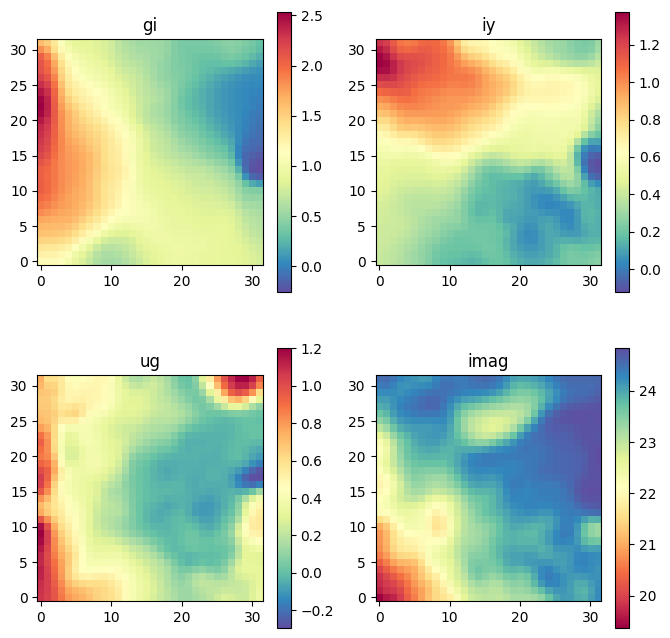

In [18]:
SOMFUNCS.somDomainColorsnok(model['deep_som'])

And now, for the deep SOM using `somDomainColors` which shows i-K in the upper right(in actuality i-F, the names are currently hardcoded):

<Figure size 600x700 with 0 Axes>

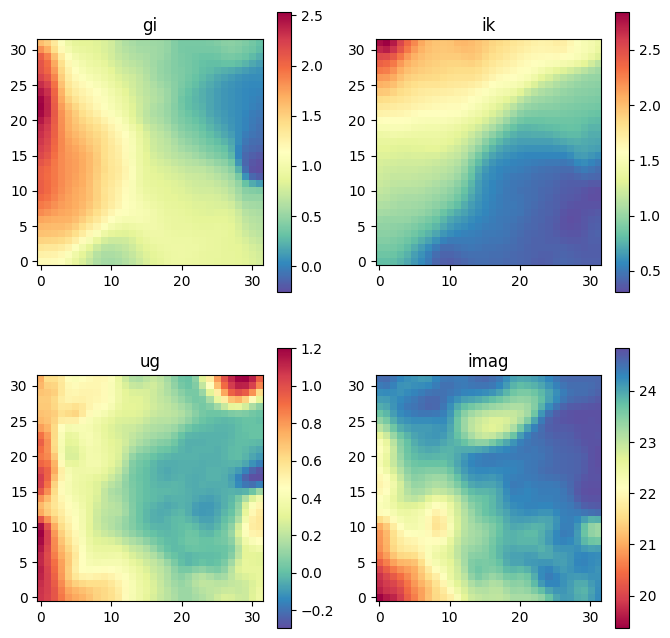

In [19]:
SOMFUNCS.somDomainColors(model['deep_som'])

For comparison, here is the `somDomainColorsnok` plots for the wide SOM:

<Figure size 1000x900 with 0 Axes>

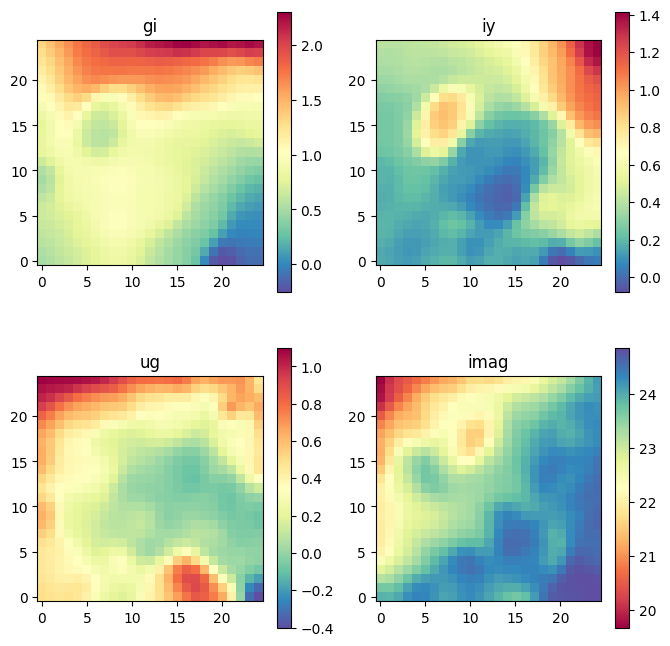

In [20]:
SOMFUNCS.somDomainColorsnok(model['wide_som'])

And, as a final visualization, here are the locations of the mean colors of each SOM cell in i-K vs g-i color space, color-coded by the mean i-band magnitude of the SOM cell:

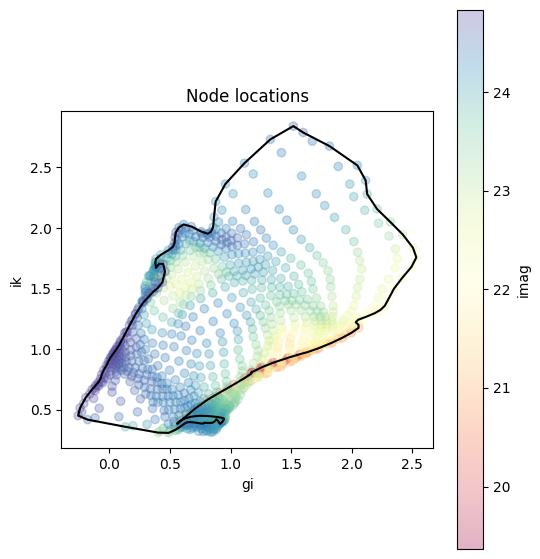

In [21]:
SOMFUNCS.somPlot2d(model['deep_som'])

This looks promising, our SOMs both show coherent patterns in color and magnitude, as they should, and will enable us to map color-space to redshift via the occupation of training galaxies in the SOMs.  In a separate notebook, `rail_sompz_estimation_demo.ipynb`, we will run the estimator stage and produce tomographic bin estimates for a test set of objects.